<a href="https://colab.research.google.com/github/khanhvy31/3DObject_Detection_DatafromLyft/blob/main/Lyft_3D_Object_Detection_for_Autonomous_Vehicles_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 . Introduction

LiDAR (Light Detection and Ranging) is a method used to **generate accurate 3D representations of the surroundings**, and it uses laser light to achieve this. 

##1.1. Import Packages Need

In [ ]:
!pip install lyft_dataset_sdk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import gc
import numpy as np
import pandas as pd

import json
import math
import sys
import time
from datetime import datetime
from typing import Tuple, List

import cv2
import matplotlib.pyplot as plt
import sklearn.metrics
from PIL import Image

from matplotlib.axes import Axes
from matplotlib import animation, rc
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import plot, init_notebook_mode
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

import seaborn as sns
from pyquaternion import Quaternion
from tqdm import tqdm

from lyft_dataset_sdk.utils.map_mask import MapMask
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import view_points, box_in_image, BoxVisibility
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from pathlib import Path

import struct
from abc import ABC, abstractmethod
from functools import reduce
from typing import Tuple, List, Dict
import copy
import warnings
warnings.filterwarnings("ignore")

##1.2. Load Dataset and Preprocessing

The annotations in train.csv are in the following format:
center_x center_y center_z width length height yaw class_name

center_x, center_y and center_z are the world coordinates of the center of the 3D bounding volume.
width, length and height are the dimensions of the volume.
yaw is the angle of the volume around the z axis (where y is forward/back, x is left/right, and z is up/down - making 'yaw' the direction the front of the vehicle / bounding box is pointing at while on the ground).
class_name is the type of object contained by the bounding volume.

###Loading Train - CSV file

In [ ]:
train = pd.read_csv('train.csv')

In [ ]:
train.head()

,Id,PredictionString
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1208.642684768659 1585.1812946970927 -23.56236...
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,848.9346793681768 2587.2870557176507 -20.15995...
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,1994.4320280494098 1128.30164336183 -18.054752...
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,1030.3877156973385 1667.13131694941 -23.764820...


###Preprocessing

In [ ]:
object_columns = ['center_x', 'center_y', 'center_z',
                  'width', 'length', 'height', 'yaw', 'class_name']
for i, values in enumerate(object_columns):
    train[values] = train['PredictionString'].str.split().str[i].tolist()

In [ ]:
train.head()

,Id,PredictionString,center_x,center_y,center_z,width,length,height,yaw,class_name
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...,2680.2830359778527,698.1969292852777,-18.04776692365821,2.064,5.488,2.053,2.6041643845397946,car
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1208.642684768659 1585.1812946970927 -23.56236...,1208.642684768659,1585.1812946970927,-23.56236391728106,1.635,4.339,1.515,-0.5649508769816922,car
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,848.9346793681768 2587.2870557176507 -20.15995...,848.9346793681768,2587.2870557176507,-20.15995655586927,1.963,4.345,1.749,-1.887128017837603,car
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,1994.4320280494098 1128.30164336183 -18.054752...,1994.4320280494098,1128.30164336183,-18.054752426906113,2.2,5.39,2.187,2.5873298432792,car
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,1030.3877156973385 1667.13131694941 -23.764820...,1030.3877156973385,1667.13131694941,-23.764820011604694,1.837,5.406,1.721,2.883587433981635,car


In [ ]:
train = train.drop(columns = 'PredictionString')
train['object_id'] = train.index
train = train.rename(columns = {'id':'sample_id'})
train = train[['Id','object_id','center_x', 'center_y', 'center_z',
                  'width', 'length', 'height', 'yaw', 'class_name']]

In [ ]:
train

,Id,object_id,center_x,center_y,center_z,width,length,height,yaw,class_name
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,0,2680.2830359778527,698.1969292852777,-18.04776692365821,2.064,5.488,2.053,2.6041643845397946,car
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1,1208.642684768659,1585.1812946970927,-23.56236391728106,1.635,4.339,1.515,-0.5649508769816922,car
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,2,848.9346793681768,2587.2870557176507,-20.15995655586927,1.963,4.345,1.749,-1.887128017837603,car
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,3,1994.4320280494098,1128.30164336183,-18.054752426906113,2.2,5.39,2.187,2.5873298432792,car
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,4,1030.3877156973385,1667.13131694941,-23.764820011604694,1.837,5.406,1.721,2.883587433981635,car
...,...,...,...,...,...,...,...,...,...,...
22675,38fa844d66a71f80c4212aadc089633cd92b11f74b0238...,22675,506.02429585132995,3074.465101403672,-2.893918837047676,2.158,5.166,1.859,1.259481574876978,car
22676,7f9a927b562c918668a4f0ee0e07d7bf80aa794afee674...,22676,635.1858391616703,3514.376608433963,-5.173128525453798,2.006,5.227,1.663,1.4299055619333982,car
22677,18d85fa438e329e996f9f522a50ae1737655123bc5a833...,22677,580.4906223985986,3341.363054644562,-0.25714443977072676,2.011,6.263,1.824,-1.8559057334179574,car
22678,5a7a365c1e92c9d7fd5592b904359142f062ed4ce64a75...,22678,501.74488889345963,3082.923914062989,-2.333889513332224,1.845,4.192,1.715,-1.8665127984084648,car


###EDA

####Distribution Plot

Number of unique class

In [ ]:
class_name = train['class_name'].unique()
print(class_name)

['car' 'pedestrian' 'other_vehicle' 'bicycle' 'bus' 'truck' 'motorcycle'
 'animal' 'emergency_vehicle']


center_x, center_y and center_z are the world coordinates of the center of the 3D bounding volume. We would like to see the distribution of the x y z of each class

center_x has multiple spikes and skew. 

Text(0.5, 1.0, 'center_x')

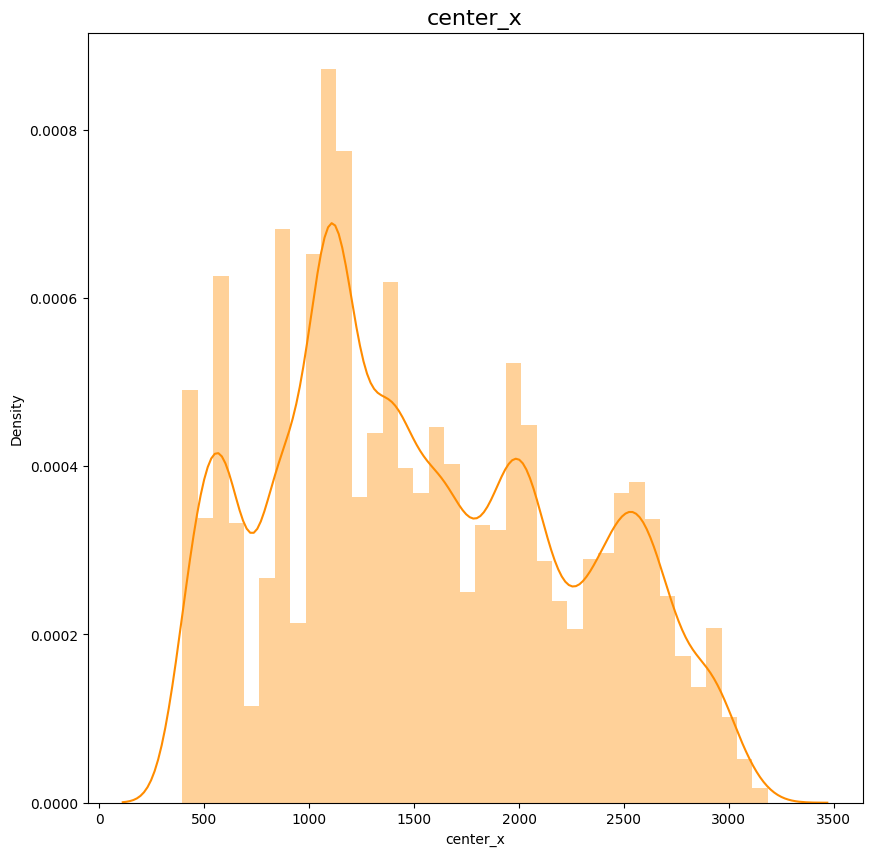

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train['center_x'], color='darkorange', ax=ax).set_title('center_x', fontsize=16)

Center_y is less skewed than center_x but also comes with multiple spikes

Text(0.5, 1.0, 'center_y')

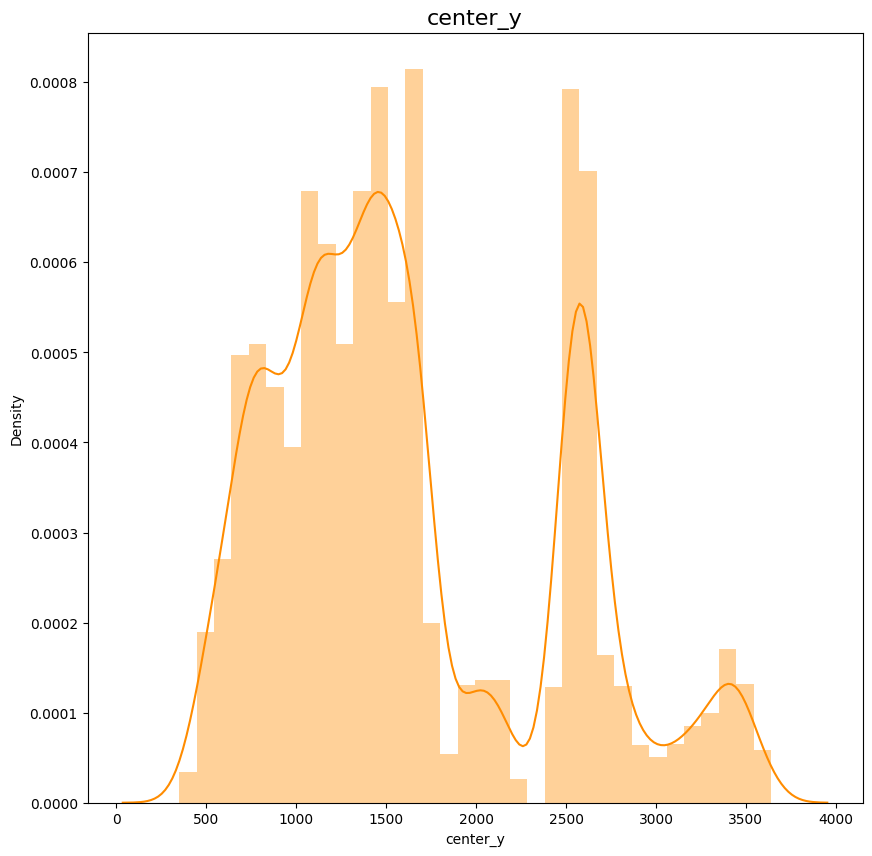

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train['center_y'], color='darkorange', ax=ax).set_title('center_y', fontsize=16)

Text(0.5, 1.0, 'center_z')

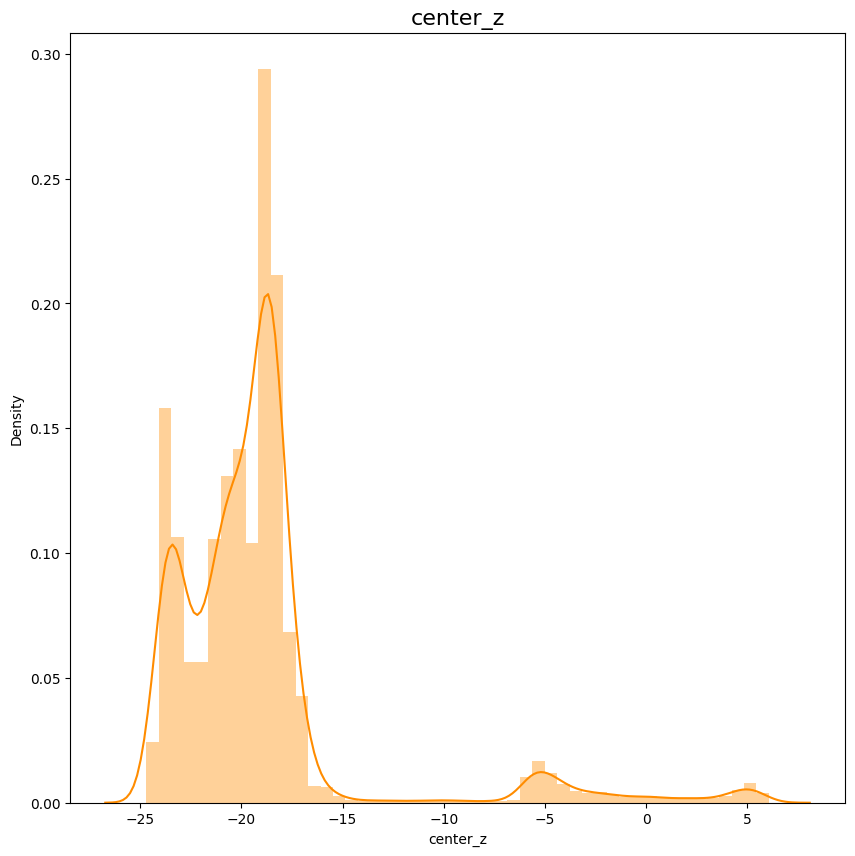

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train['center_z'], color='darkorange', ax=ax).set_title('center_z', fontsize=16)

In [ ]:
train

,Id,object_id,center_x,center_y,center_z,width,length,height,yaw,class_name
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,0,2680.2830359778527,698.1969292852777,-18.04776692365821,2.064,5.488,2.053,2.6041643845397946,car
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1,1208.642684768659,1585.1812946970927,-23.56236391728106,1.635,4.339,1.515,-0.5649508769816922,car
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,2,848.9346793681768,2587.2870557176507,-20.15995655586927,1.963,4.345,1.749,-1.887128017837603,car
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,3,1994.4320280494098,1128.30164336183,-18.054752426906113,2.2,5.39,2.187,2.5873298432792,car
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,4,1030.3877156973385,1667.13131694941,-23.764820011604694,1.837,5.406,1.721,2.883587433981635,car
...,...,...,...,...,...,...,...,...,...,...
22675,38fa844d66a71f80c4212aadc089633cd92b11f74b0238...,22675,506.02429585132995,3074.465101403672,-2.893918837047676,2.158,5.166,1.859,1.259481574876978,car
22676,7f9a927b562c918668a4f0ee0e07d7bf80aa794afee674...,22676,635.1858391616703,3514.376608433963,-5.173128525453798,2.006,5.227,1.663,1.4299055619333982,car
22677,18d85fa438e329e996f9f522a50ae1737655123bc5a833...,22677,580.4906223985986,3341.363054644562,-0.25714443977072676,2.011,6.263,1.824,-1.8559057334179574,car
22678,5a7a365c1e92c9d7fd5592b904359142f062ed4ce64a75...,22678,501.74488889345963,3082.923914062989,-2.333889513332224,1.845,4.192,1.715,-1.8665127984084648,car


Since Yaw is the direction the front of the vehicle / bounding box is pointing at while on the ground. It is making sense that it is fluctuated. 

Text(0.5, 1.0, 'yaw')

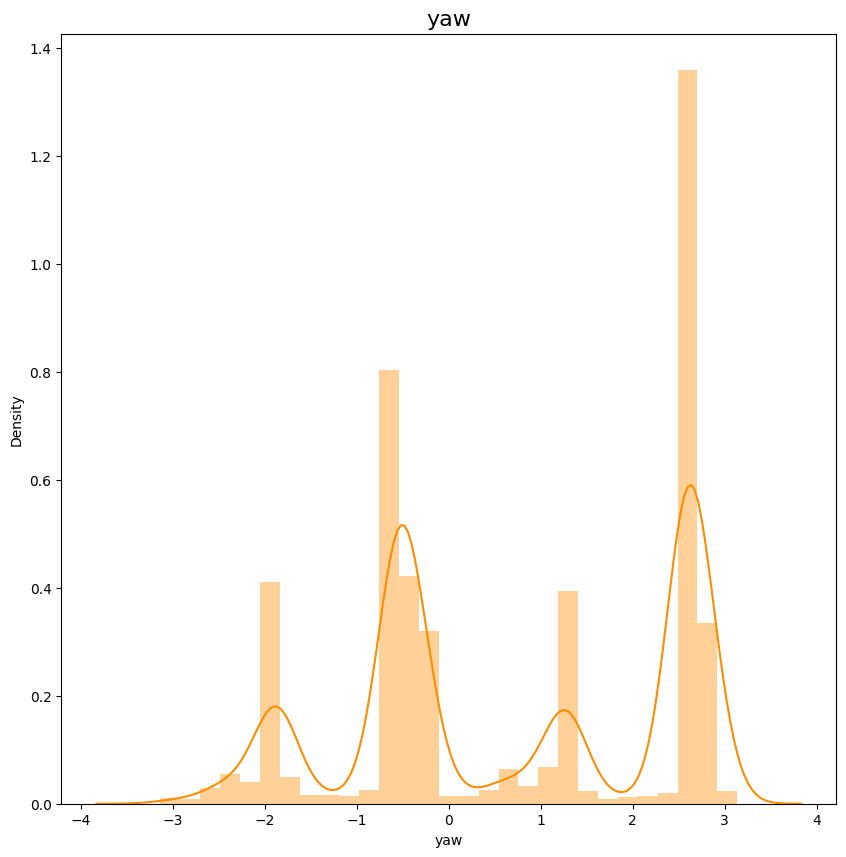

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train['yaw'], color='darkorange', ax=ax).set_title('yaw', fontsize=16)

####Distribution Plot for center_x and center_y of Each Class

Let's see with different classes, how different the distribution are

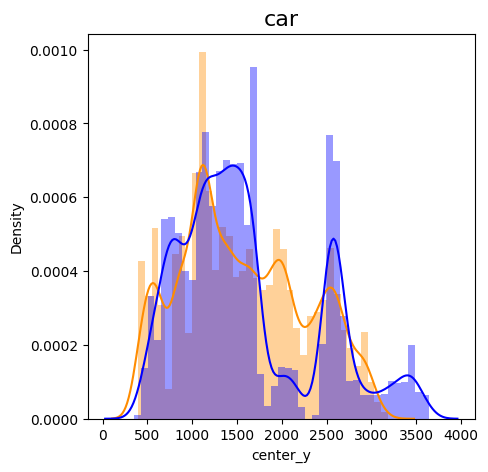

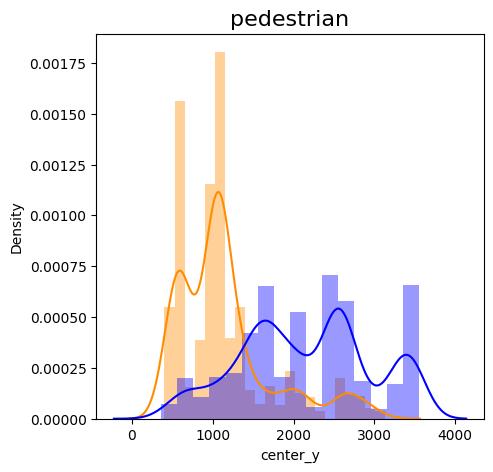

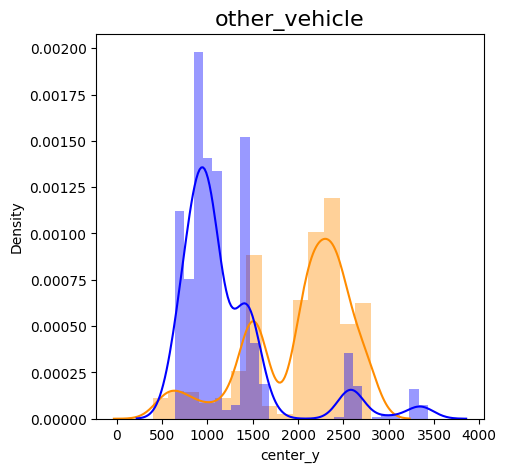

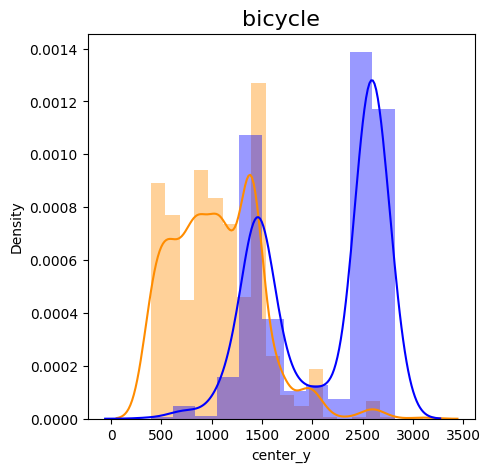

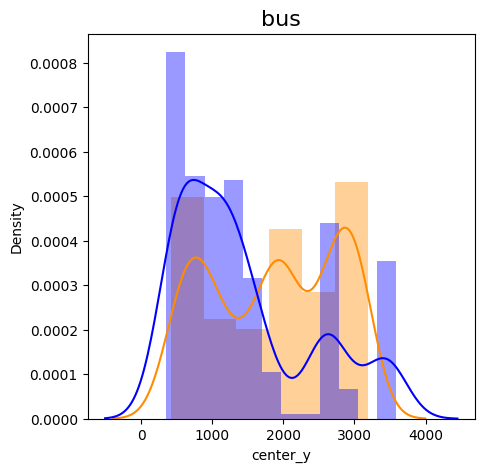

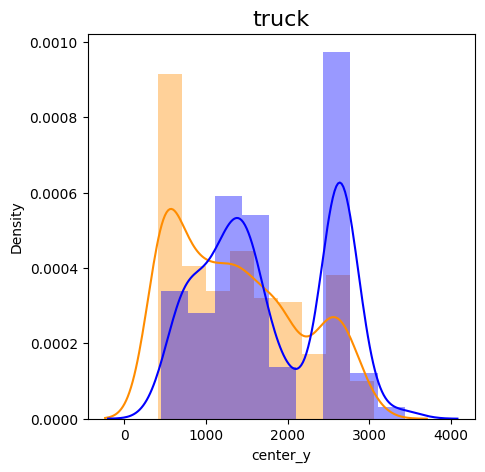

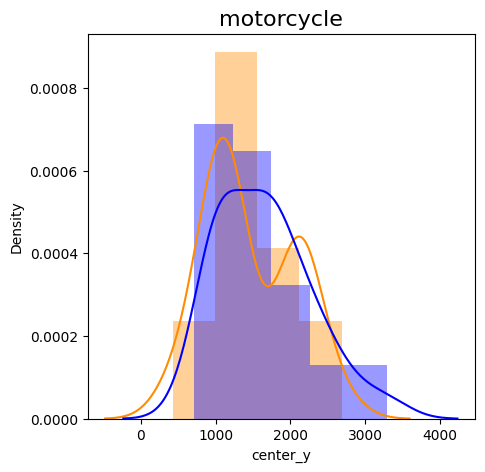

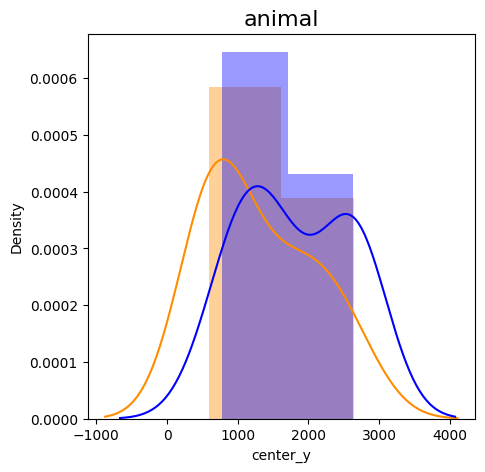

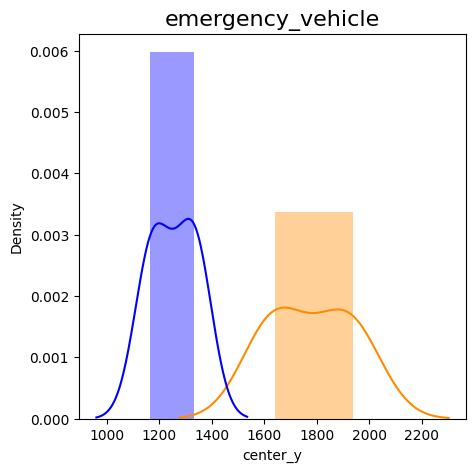

In [ ]:
for i in train['class_name'].unique():
  newtrain = train[train['class_name']==i]
  fig, ax = plt.subplots(figsize=(5, 5))
  sns.distplot(newtrain['center_x'], color='darkorange', ax=ax).set_title(i, fontsize=16)
  sns.distplot(newtrain['center_y'], color='blue', ax=ax).set_title(i, fontsize=16)
  plt.show()

Very interesting findings from those distribution plots. For animal, pedestrian, motocycle, the x and y are very different and easy to distinguish from each other. 

####Distribution Plot for Yaw of each class

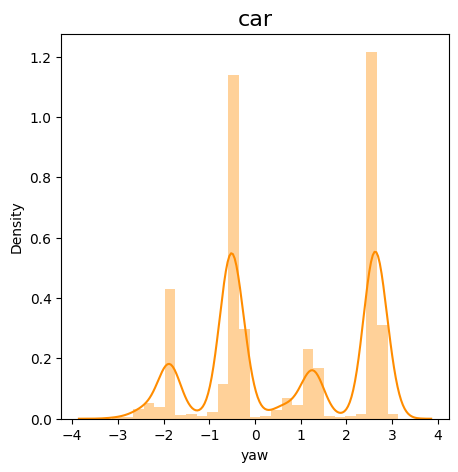

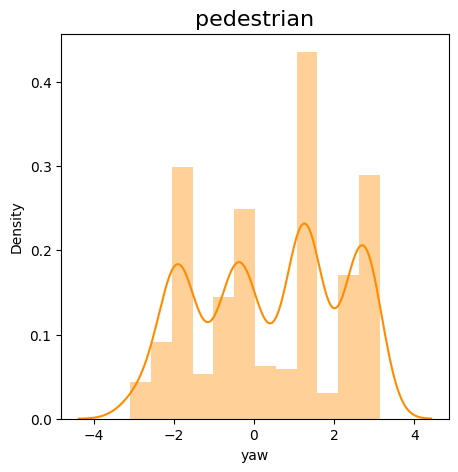

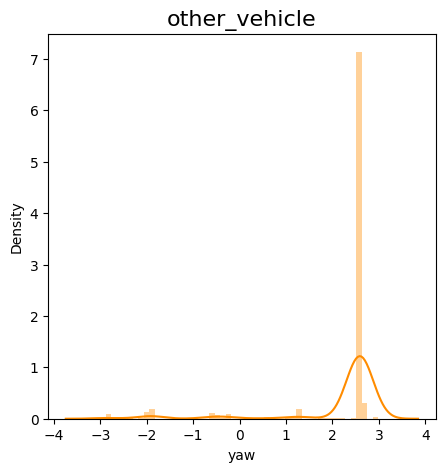

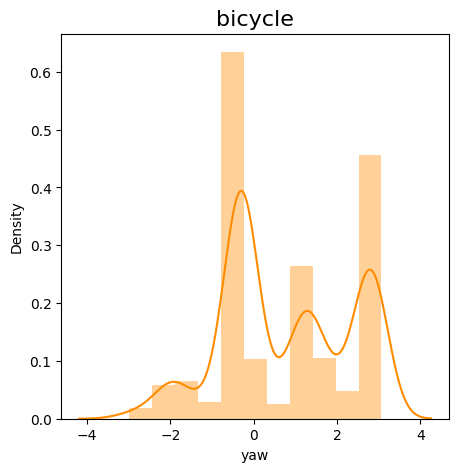

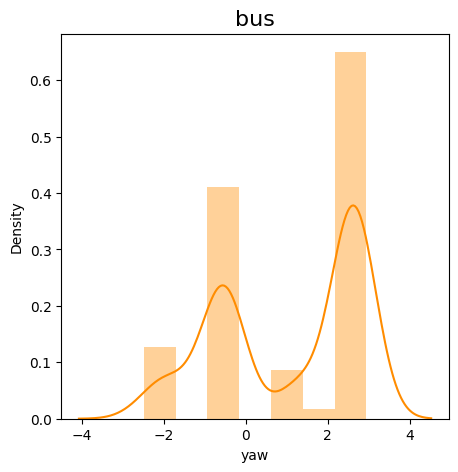

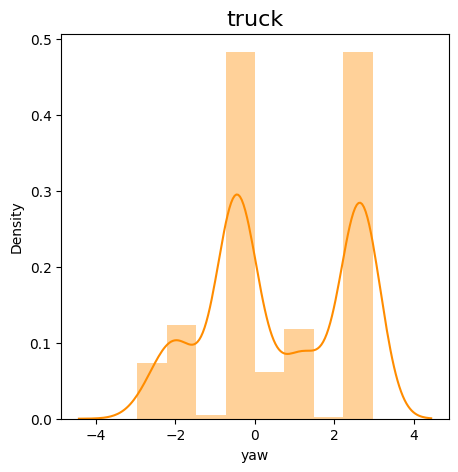

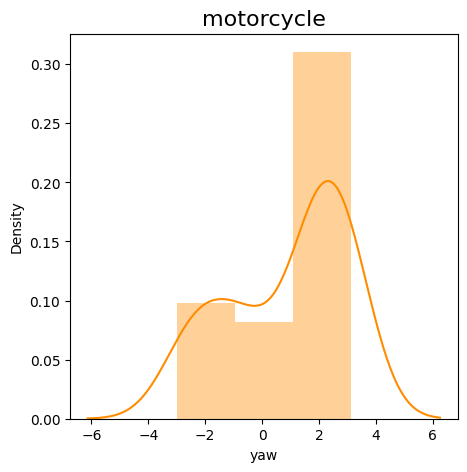

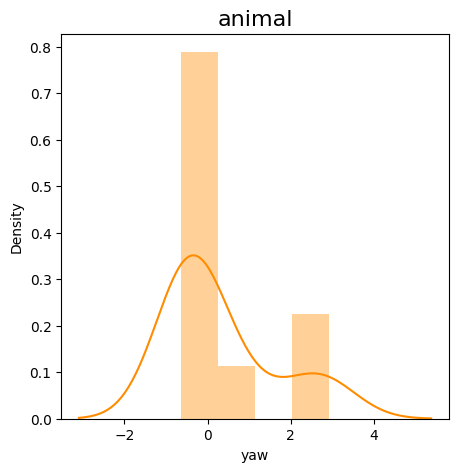

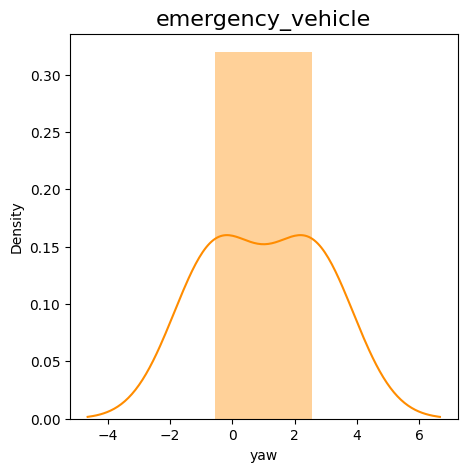

In [ ]:
for i in train['class_name'].unique():
  newtrain = train[train['class_name']==i]
  fig, ax = plt.subplots(figsize=(5, 5))
  sns.distplot(newtrain['yaw'], color='darkorange', ax=ax).set_title(i, fontsize=16)
  plt.show()

As we can see that the emergency_vehicle, pedestrian have unique shape of yaw, this could be an interesting feature that highly correlated to the label in order to identify the object classification

####Violin Distribution Plot - Center x

Emergency_vehicle, pedestrian motocycle and animal play their own game in this dataset. Therefore, when plotting violin plot, I will take out these classes

In [ ]:
train

,Id,object_id,center_x,center_y,center_z,width,length,height,yaw,class_name
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,0,2680.2830359778527,698.1969292852777,-18.04776692365821,2.064,5.488,2.053,2.6041643845397946,car
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1,1208.642684768659,1585.1812946970927,-23.56236391728106,1.635,4.339,1.515,-0.5649508769816922,car
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,2,848.9346793681768,2587.2870557176507,-20.15995655586927,1.963,4.345,1.749,-1.887128017837603,car
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,3,1994.4320280494098,1128.30164336183,-18.054752426906113,2.2,5.39,2.187,2.5873298432792,car
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,4,1030.3877156973385,1667.13131694941,-23.764820011604694,1.837,5.406,1.721,2.883587433981635,car
...,...,...,...,...,...,...,...,...,...,...
22675,38fa844d66a71f80c4212aadc089633cd92b11f74b0238...,22675,506.02429585132995,3074.465101403672,-2.893918837047676,2.158,5.166,1.859,1.259481574876978,car
22676,7f9a927b562c918668a4f0ee0e07d7bf80aa794afee674...,22676,635.1858391616703,3514.376608433963,-5.173128525453798,2.006,5.227,1.663,1.4299055619333982,car
22677,18d85fa438e329e996f9f522a50ae1737655123bc5a833...,22677,580.4906223985986,3341.363054644562,-0.25714443977072676,2.011,6.263,1.824,-1.8559057334179574,car
22678,5a7a365c1e92c9d7fd5592b904359142f062ed4ce64a75...,22678,501.74488889345963,3082.923914062989,-2.333889513332224,1.845,4.192,1.715,-1.8665127984084648,car


In [ ]:
train.columns


Index(['Id', 'object_id', 'center_x', 'center_y', 'center_z', 'width',
       'length', 'height', 'yaw', 'class_name'],
      dtype='object')

In [ ]:
columns = 'center_x', 'center_y', 'center_z', 'width','length', 'height', 'yaw'
for i in columns:
  train[i] = train[i].astype('float')

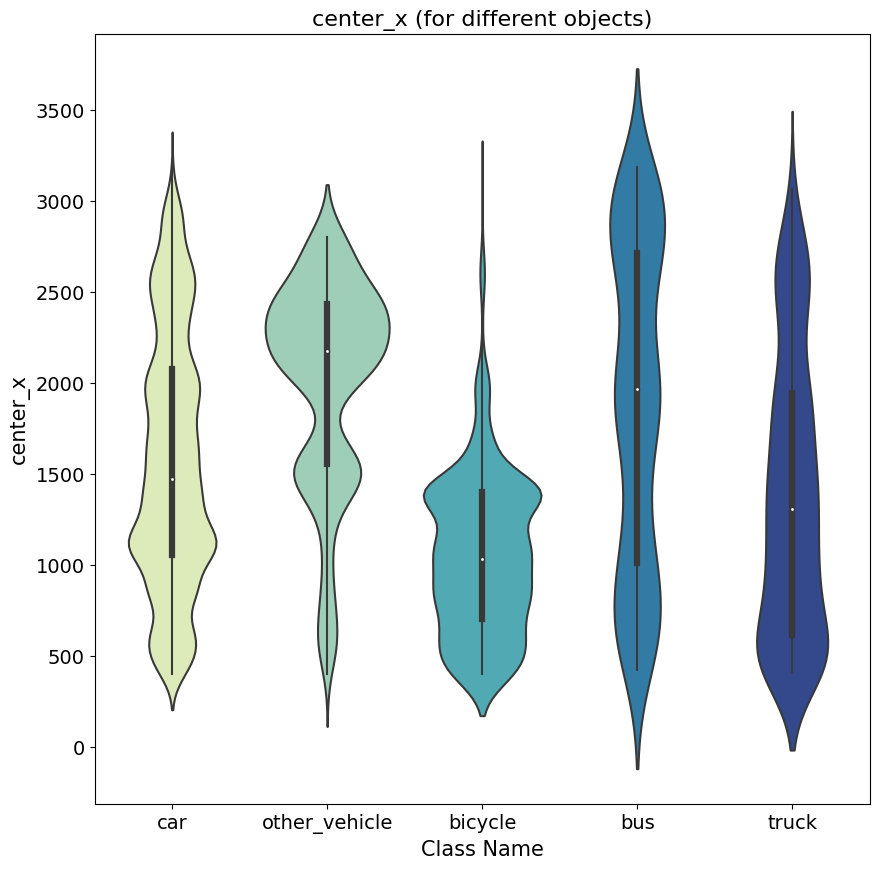

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

plot = sns.violinplot(x='class_name', y='center_x',
                      data=train.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "pedestrian" and class_name != "animal"'),
                      palette='YlGnBu',
                      split=True, ax=ax).set_title('center_x (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("center_x", fontsize=15)
plt.show(plot)

####Violin Distribution Plot - Center y

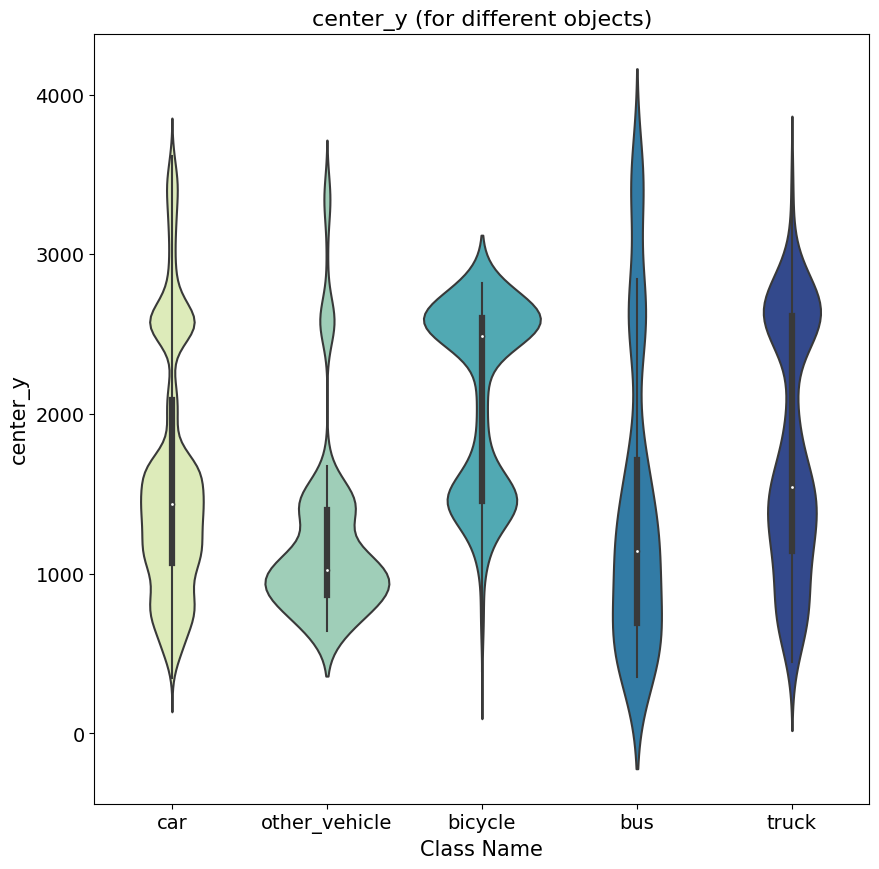

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

plot = sns.violinplot(x='class_name', y='center_y',
                      data=train.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "pedestrian" and class_name != "animal"'),
                      palette='YlGnBu',
                      split=True, ax=ax).set_title('center_y (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("center_y", fontsize=15)
plt.show(plot)

####Violin Distribution Plot - Center z

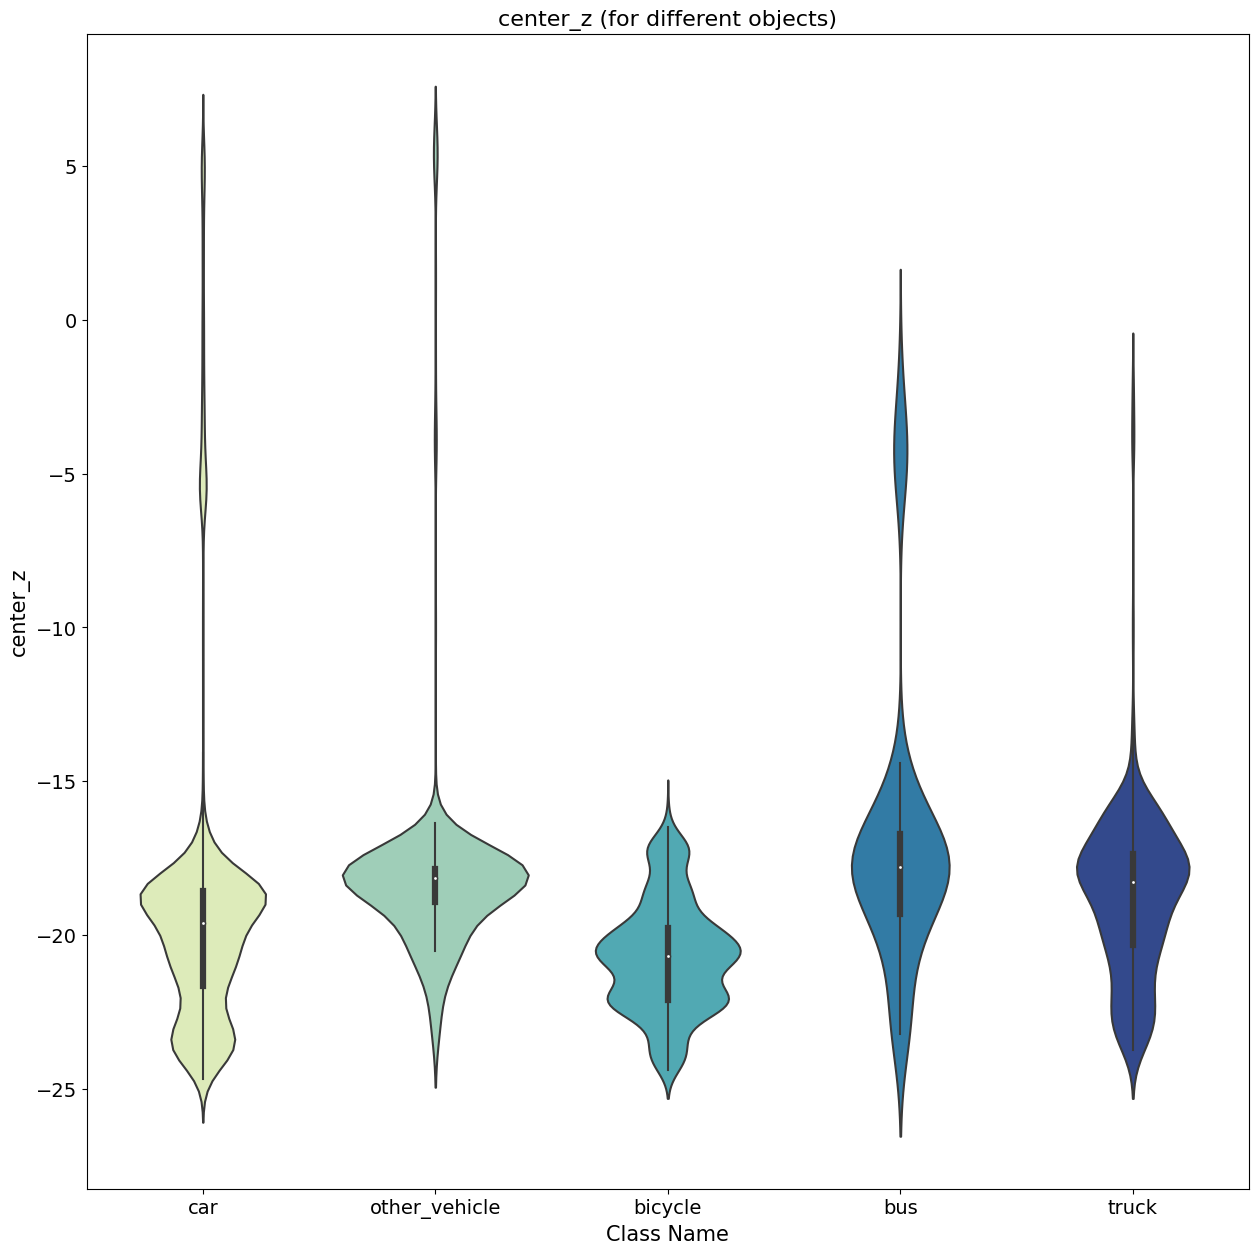

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.violinplot(x='class_name', y='center_z',
                      data=train.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "pedestrian" and class_name != "animal"'),
                      palette='YlGnBu',
                      split=True, ax=ax).set_title('center_z (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("center_z", fontsize=15)
plt.show(plot)

####Box Plot - width

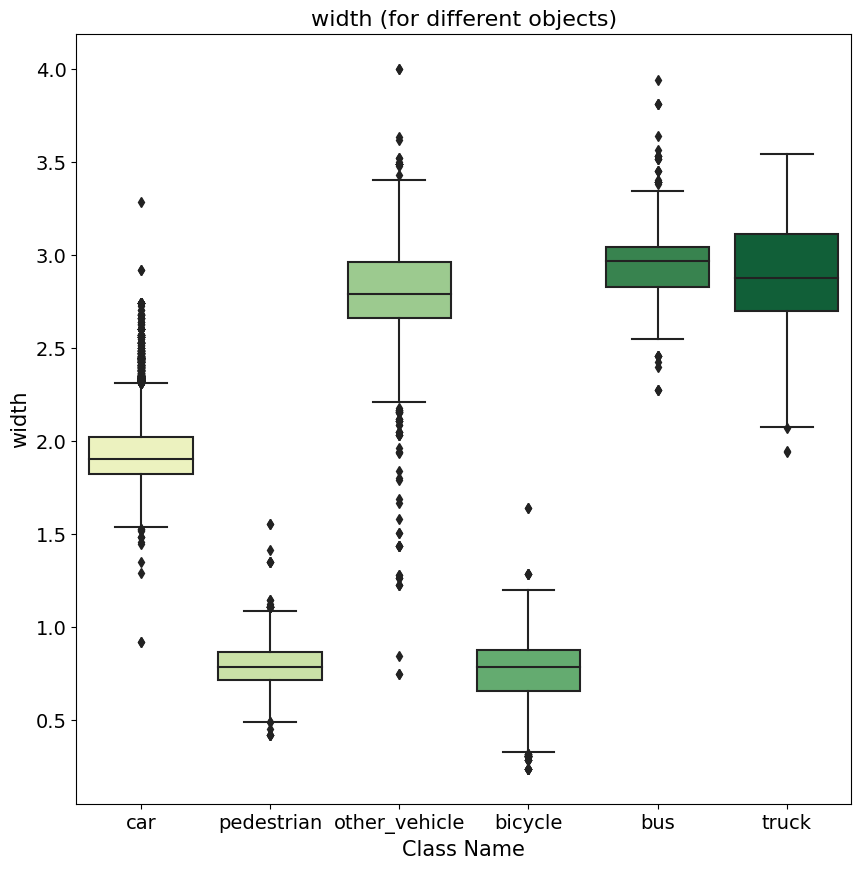

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

plot = sns.boxplot(x="class_name", y="width",
                   data=train.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                   palette='YlGn', ax=ax).set_title('width (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("width", fontsize=15)
plt.show(plot)

####Box Plot - Height

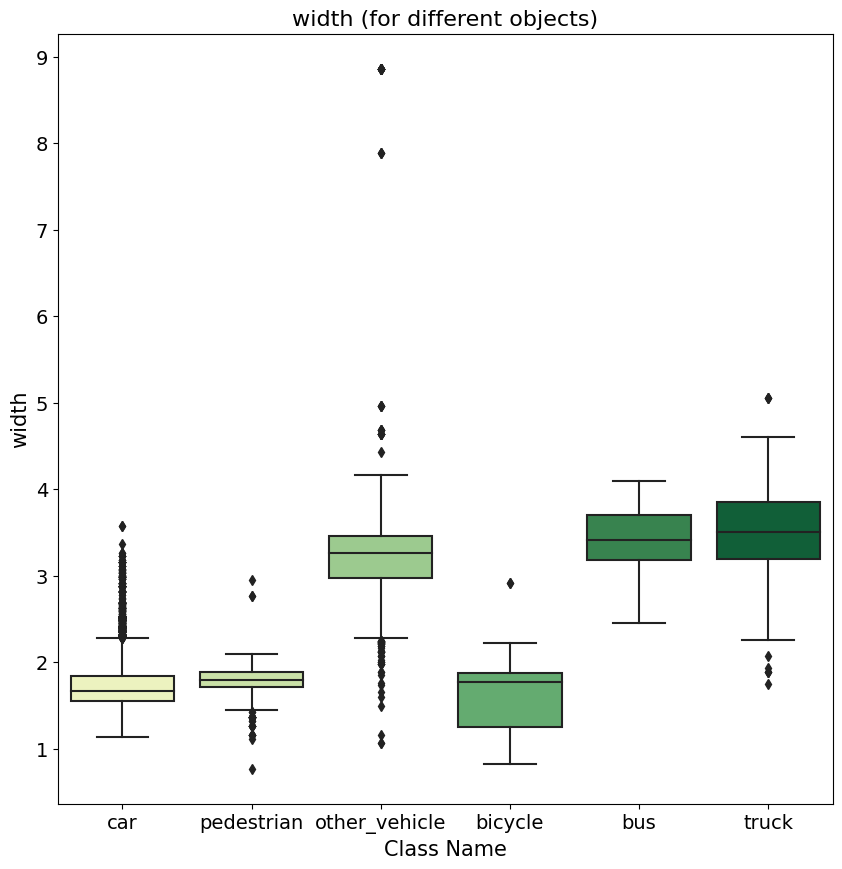

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

plot = sns.boxplot(x="class_name", y="height",
                   data=train.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                   palette='YlGn', ax=ax).set_title('width (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("width", fontsize=15)
plt.show(plot)

####Box Plot - Length

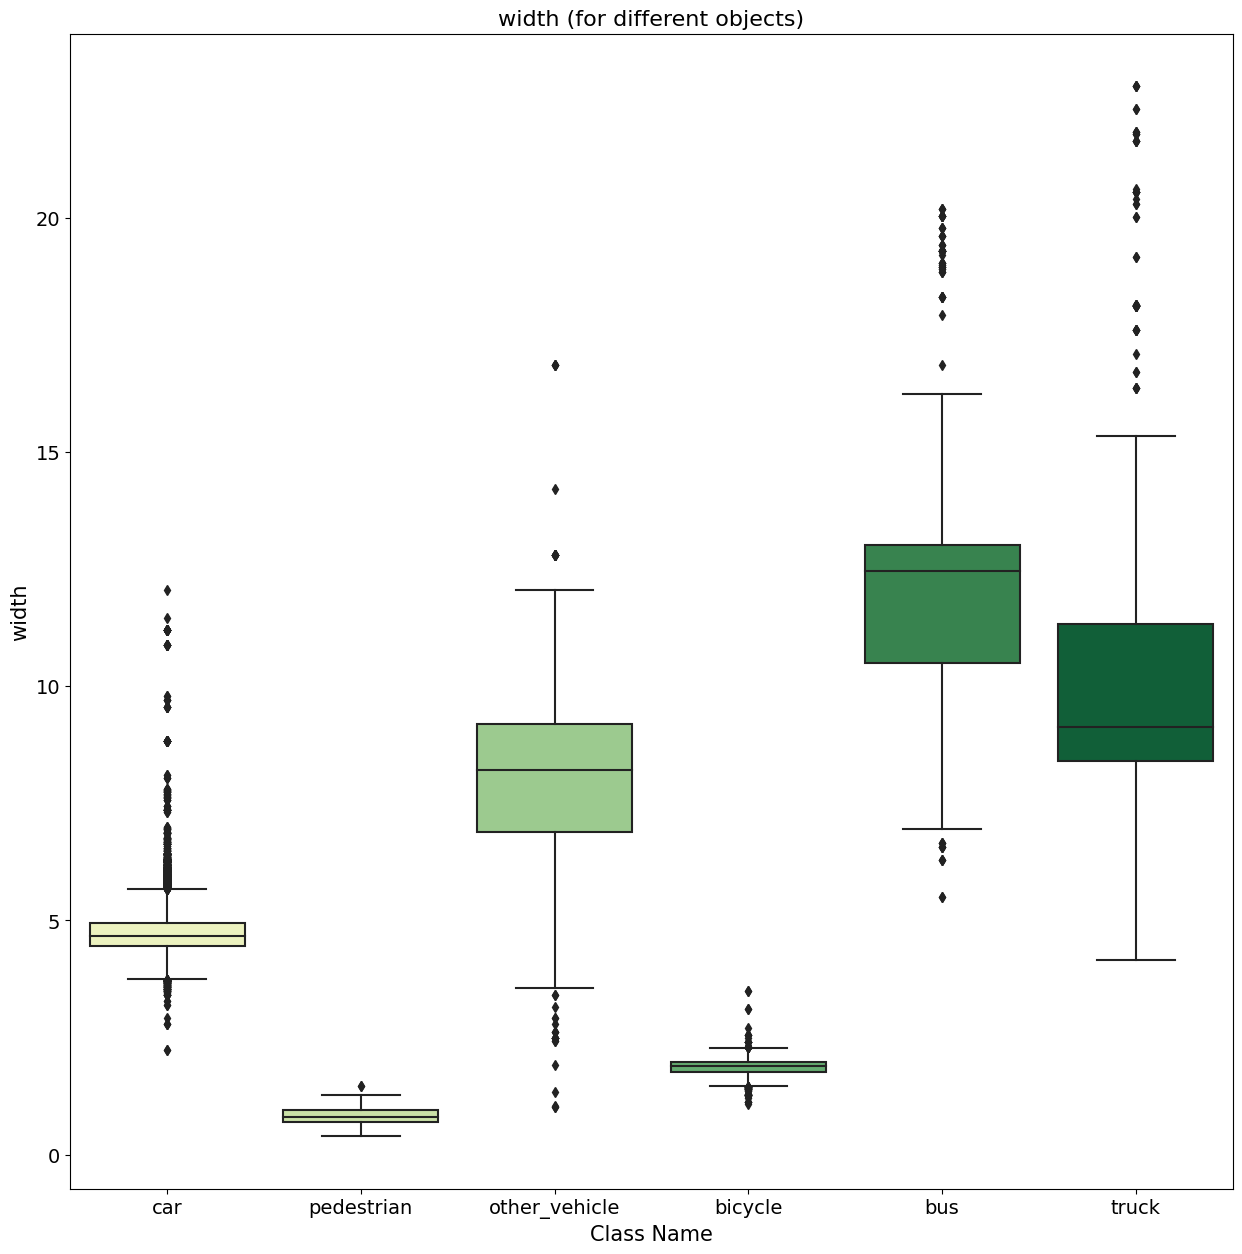

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="class_name", y="length",
                   data=train.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                   palette='YlGn', ax=ax).set_title('width (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("width", fontsize=15)
plt.show(plot)

As we can see, bus and truck are similar in terms of width, length and height, same as pedestrian and bicycle

####Correlation Matrix between feature

In [ ]:
corr_df = train.drop(columns =['Id','object_id','class_name'])

In [ ]:
print(corr_df.columns)

Index(['center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw'], dtype='object')


In [ ]:
for i in corr_df.columns:
  corr_df[i] = corr_df[i].astype('float')


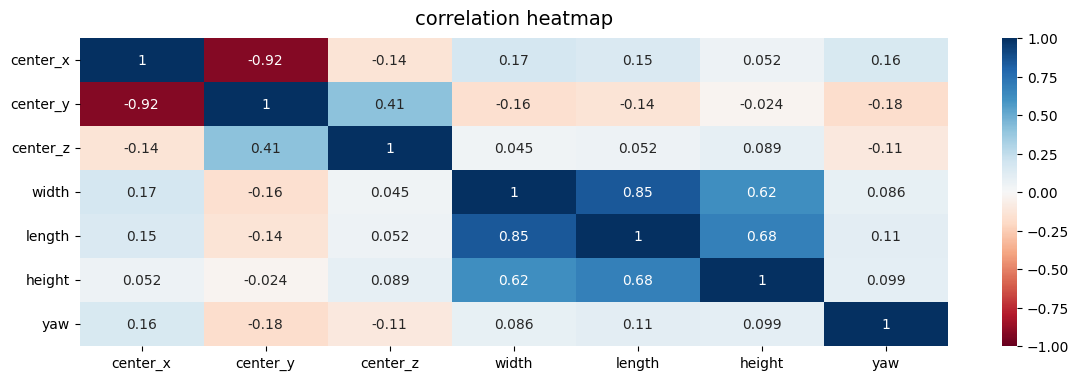

In [ ]:
corr_matrix = corr_df.corr()
plt.figure(figsize = (14,4))
heatmap = sns.heatmap(corr_matrix, vmin = -1, vmax = 1, annot = True, cmap = 'RdBu')
heatmap.set_title('correlation heatmap',fontdict = {'fontsize':14},pad=10);

**Key Takaway: **As distribution plot, we can see that center_x and center_y are highly correlated to each other. Same with length, height and yaw. Using PCA or Regularization will help in this case